In [14]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import pandas as pd
import glob
import pickle
import numpy as np
from csslconstants import *
from cmcrameri import cm

os.chdir(homedir)


In [30]:
## load data from the prep_cssl_data.py process
with open(datadir + 'cssldata.pickle', 'rb') as handle:
    cssl = pickle.load(handle)

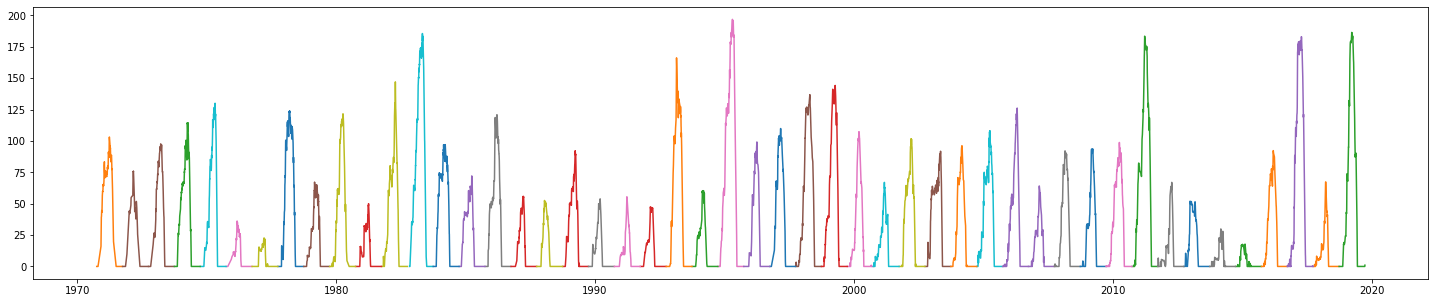

In [31]:
fig,ax = plt.subplots(figsize=(25,5))
for k in cssl.keys():
    data = cssl[k]
    y = pd.Series(data['Snow Water Equivalent (cm)'])
    y.index = index=data['dt']
    y2 = y.interpolate()
    ax.plot(y2)

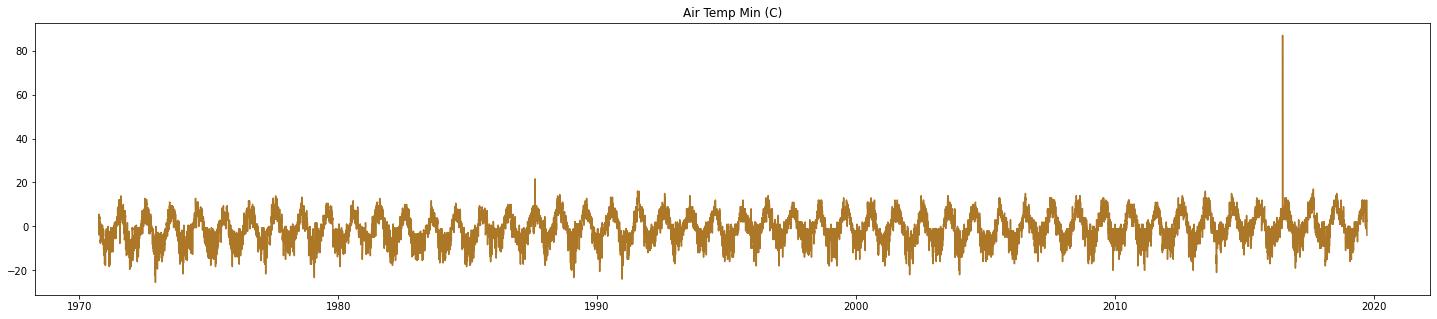

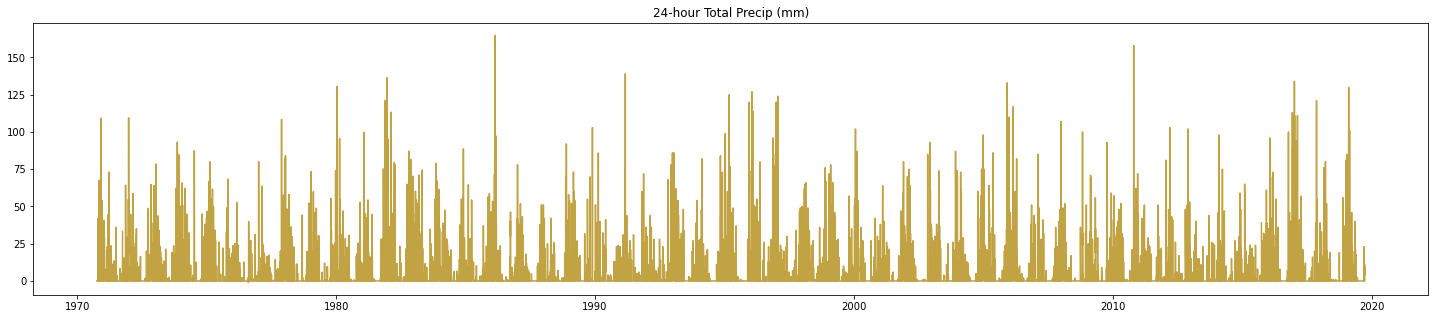

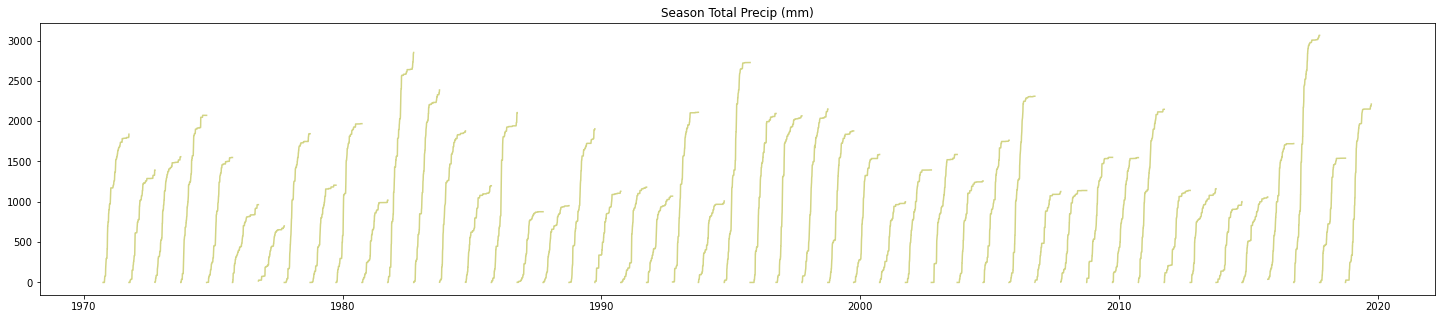

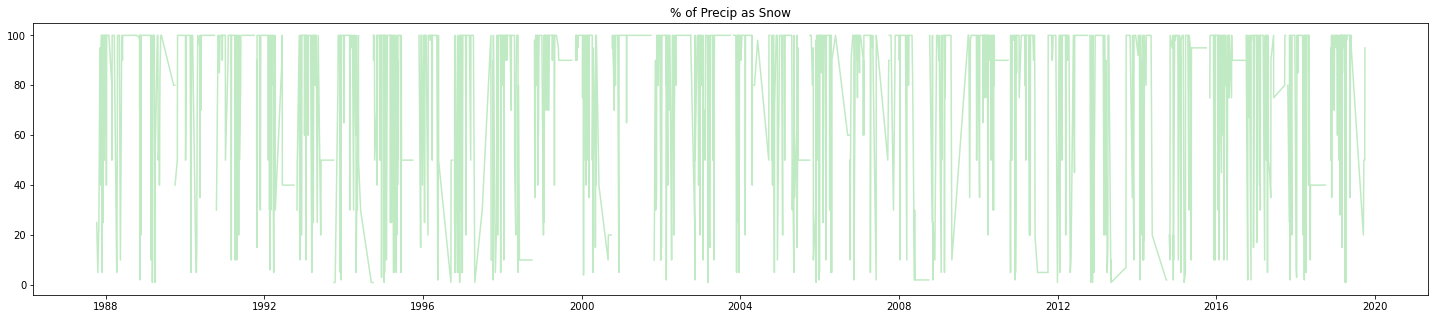

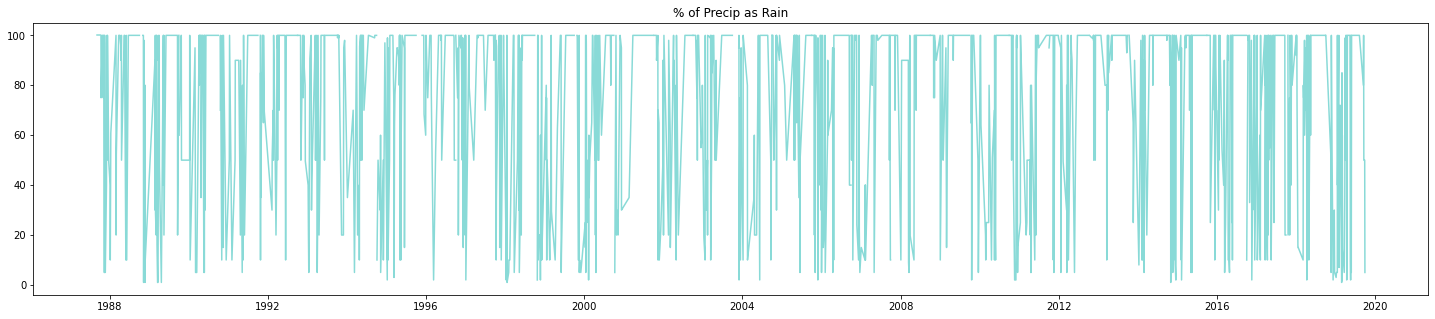

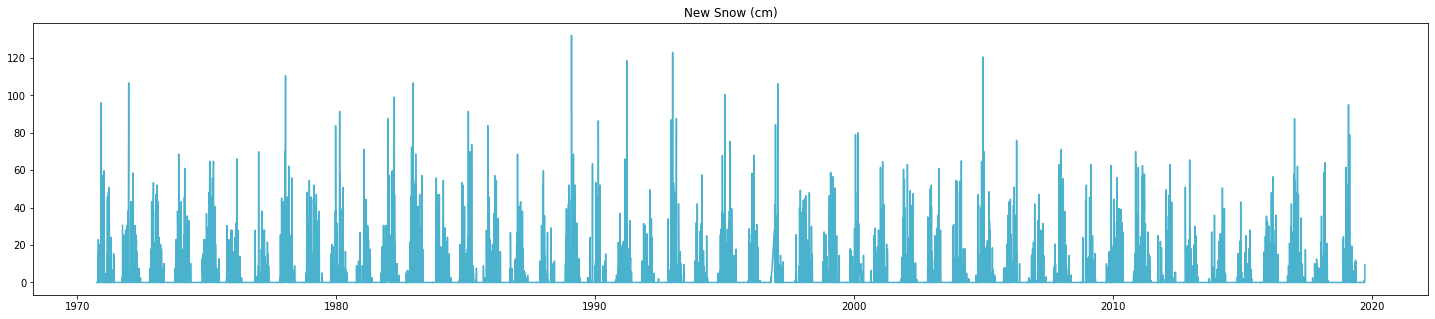

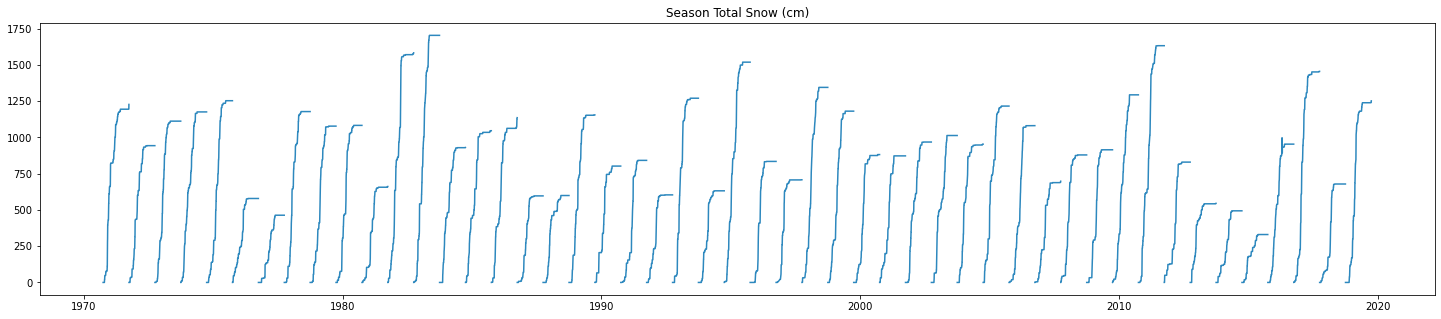

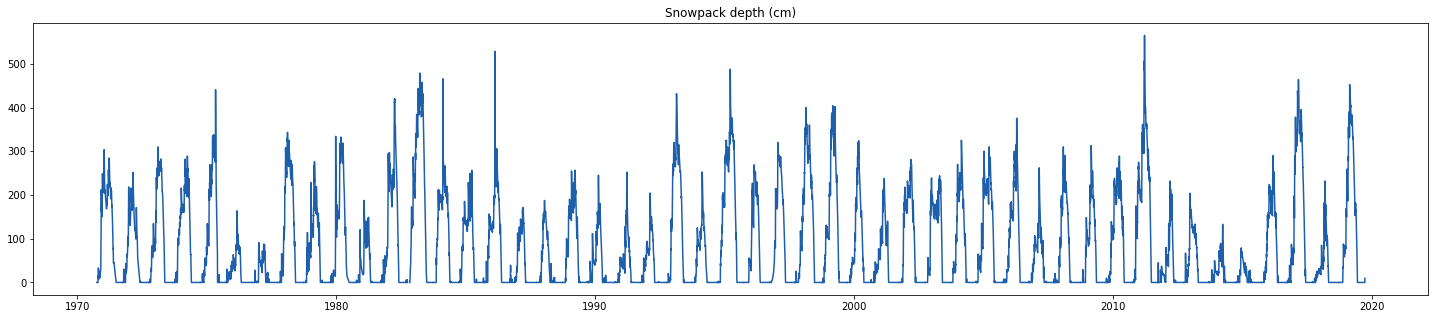

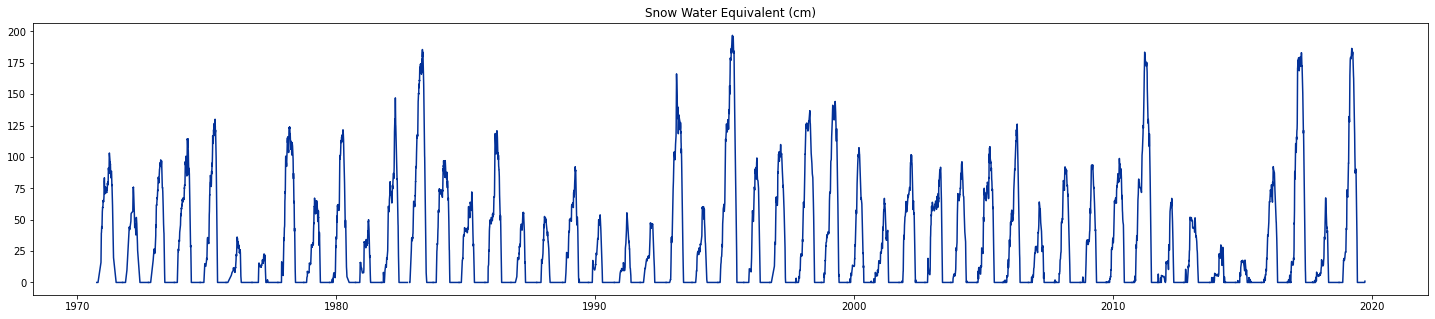

In [32]:
cols = cm.roma(np.linspace(0,1,11))
for i in range(2,len(datakeys)-2):
    fig,ax = plt.subplots(figsize=(25,5))
    color = cols[i]
    for k in cssl.keys():
        data = cssl[k]
        try:
            y = pd.Series(data[datakeys[i]].astype('float'))
            y.index = index=data['dt']
            y2 = y.interpolate()
            ax.plot(y2,color=color)
            ax.set_title(datakeys[i])
        except:
            print(datakeys[i],k)
            continue

Text(0.5, 0, 'depth')

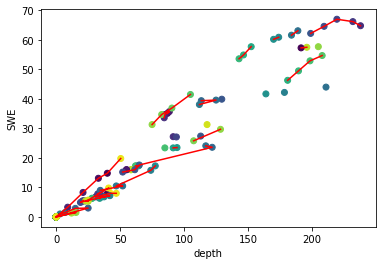

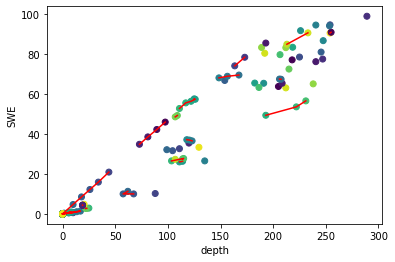

In [33]:
fig,ax=plt.subplots()
for k in ['2001']: # cssl.keys():
    data = cssl[k]
    x = pd.Series(data['Snowpack depth (cm)'].astype('float'))
    y = pd.Series(data['Snow Water Equivalent (cm)'].astype('float'))
    tmp = pd.Series(data['dt'])
    z =  [t.day for t in tmp]
    y.index = index=data['dt']
    ax.scatter(x,y,c= z, label=k)
    ax.plot(x,y,color='r')

# ax.legend()
ax.set_ylabel('SWE')
ax.set_xlabel('depth')

fig,ax=plt.subplots()
for k in ['2010']: # cssl.keys():
    data = cssl[k]
    x = pd.Series(data['Snowpack depth (cm)'].astype('float'))
    y = pd.Series(data['Snow Water Equivalent (cm)'].astype('float'))
    tmp = pd.Series(data['dt'])
    z =  [t.day for t in tmp]
    y.index = index=data['dt']
    ax.scatter(x,y,c= z, label=k)
    ax.plot(x,y,color='r')

# ax.legend()
ax.set_ylabel('SWE')
ax.set_xlabel('depth')


In [34]:
## what is the appropriate way to handle this as a state space model?